In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("ticks")
sns.set_context("talk")

colors = sns.color_palette()

Parameters

In [2]:
# Parameters
LAMBDA = 1         # Wavelength
N = 50             # Number of grid points per wavelength
DELTA = 1 / N      # Grid spacing
TAU = 0.9 * DELTA  # Courant condition: 0.9*DELTA, 1.05 * DELTA
X = 100 * LAMBDA   # Length of the simulation box
L = X / DELTA      # Number of grid points

# Source parameters
f = 1                  # Source frequency
omega = 2 * np.pi * f  # Source angular frequency

# Simulation parameters
m = 10**4          # Number of time steps

# Optical properties
n = 1.46           # Refractive index

# Simulation time steps
ts = np.arange(0, m * TAU, TAU)

Material properties

In [3]:
def sigma(x, LAMBDA=LAMBDA, L=L, DELTA=1/N):
    """
    Create the conductivity profile for the boundary layers.
    """
    
    sigma = np.zeros_like(x)

    sigma[(0 <= x) & (x <= 6 * LAMBDA)] = 1.0
    sigma[(6 * LAMBDA < x) & (x < L * DELTA - 6 * LAMBDA)] = 0.0
    sigma[(L * DELTA - 6 * LAMBDA <= x) & (x <= L * DELTA)] = 1.0
    return sigma

def epsilon(x, mode="thin", LAMBDA=LAMBDA, L=L, DELTA=1/N, n=n):
    """
    Create the permittivity profile for the glass layer. The glass layer can be either thin or thick.
    """

    epsilon = np.zeros_like(x)

    if mode == "thin":
        epsilon[(0 <= x) & (x < L * DELTA / 2)] = 1.0
        epsilon[(L * DELTA / 2 <= x) & (x < L * DELTA / 2 + 2 * LAMBDA)] = n**2
        epsilon[(L * DELTA / 2 + 2 * LAMBDA <= x) & (x <= L * DELTA)] = 1.0
    
    elif mode == "thick":
        epsilon[(0 <= x) & (x < L * DELTA / 2)] = 1.0
        epsilon[(L * DELTA / 2 <= x) & (x <= L * DELTA)] = n**2
    
    else:
        raise ValueError("Mode must be 'thin' or 'thick'")
    return epsilon

def sigma_star(x):
    """
    Create magnetic loss profile.
    """

    sigma_star = np.zeros_like(x)

    sigma_star[(0 <= x) & (x <= 6 * LAMBDA)] = 1.0
    sigma_star[(6 * LAMBDA < x) & (x < L * DELTA - 6 * LAMBDA)] = 0.0
    sigma_star[(L * DELTA - 6 * LAMBDA <= x) & (x <= L * DELTA)] = 1.0
    return sigma_star

def mu(x):
    """
    Create magnetic permeability profile.
    """

    mu = np.ones_like(x)
    return mu

Current source

In [4]:
# Source position and index
x_s = 20 * LAMBDA
i_s = int(x_s // DELTA)

def j_s(ts, omega=omega):
    """
    Current source function
    """

    j_s = np.sin(omega * ts) * np.exp(-(((ts - 30) / 10) ** 2))
    return j_s

### Thin glass

In [5]:
# Grid point positions
x_E = np.arange(0, L+1) * DELTA
x_H = (np.arange(0, L) + 1 / 2) * DELTA

# Initialize fields
E_z = np.zeros_like(x_E)
H_y = np.zeros_like(x_H)

In [6]:
# Initialize auxiliary fields

C = (1 - (sigma(x_E) * TAU) / (2 * epsilon(x_E))) / (1 + (sigma(x_E) * TAU) / (2 * epsilon(x_E)))
D = (TAU / epsilon(x_E)) / (1 + (sigma(x_E) * TAU) / (2 * epsilon(x_E)))

A = (1 - (sigma_star(x_H) * TAU) / (2 * mu(x_H))) / (1 + (sigma_star(x_H) * TAU) / (2 * mu(x_H)))
B = (TAU / mu(x_H)) / (1 + (sigma_star(x_H) * TAU) / (2 * mu(x_H)))

In [7]:
def plot_E(x_E, E_z, mode="thin", title=None, show=True):
    """
    Plot the electric field.
    """
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    # Plot the electric field and source
    ax.plot(x_E, E_z, color=colors[0])
    ax.plot(x_s, 0, 'o', color=colors[3], label="Source")
    
    # Plot the glass layer
    if mode == "thin":
        ax.fill_between([0, 6 * LAMBDA], -0.02, 0.02, color=colors[7], alpha=0.5)
        ax.fill_between([L * DELTA / 2, L * DELTA / 2 + 2 * LAMBDA], -0.02, 0.02, color=colors[2], alpha=0.5)
        ax.fill_between([L * DELTA - 6 * LAMBDA, L * DELTA], -0.02, 0.02, color=colors[7], alpha=0.5)
    
    elif mode == "thick":
        ax.fill_between([0, 6 * LAMBDA], -0.02, 0.02, color=colors[7], alpha=0.5)
        ax.fill_between([L * DELTA / 2, L * DELTA], -0.02, 0.02, color=colors[2], alpha=0.5)
        ax.fill_between([L * DELTA - 6 * LAMBDA, L * DELTA], -0.02, 0.02, color=colors[7], alpha=0.5)

    ax.set_xlim(0, L * DELTA)
    ax.set_ylim(-0.022, 0.022)

    ax.set_yticks(np.arange(-0.02, 0.03, 0.01))

    ax.set_xlabel(r"x / $\lambda$")
    ax.set_ylabel(r"E$_z$")

    if title is not None:
        ax.set_title(title)

    ax.grid()
    ax.legend()

    plt.tight_layout()
    sns.despine()    
    if show:
        plt.show()
    return fig, ax

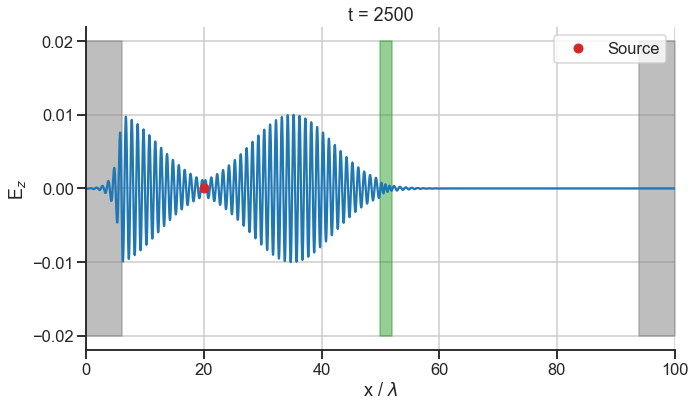

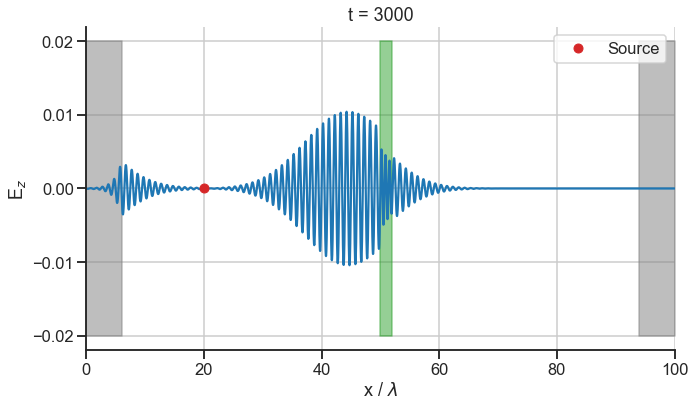

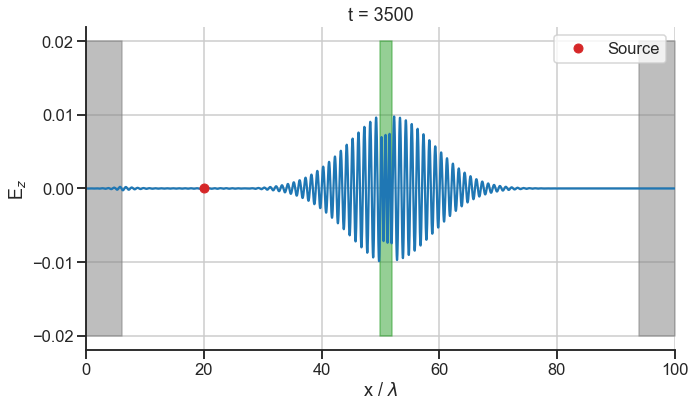

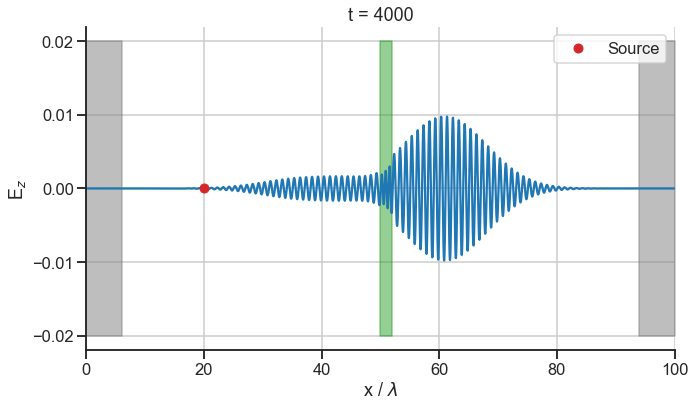

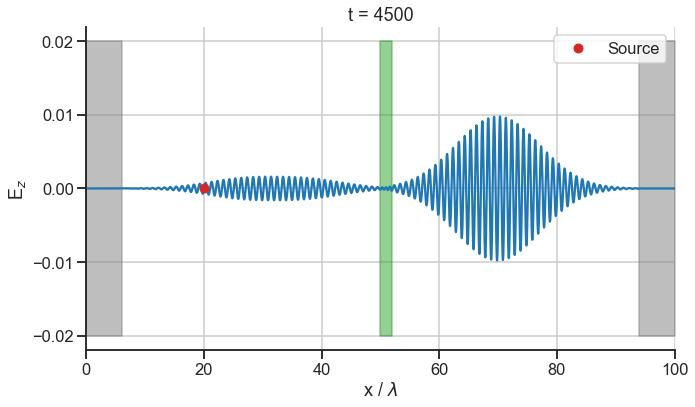

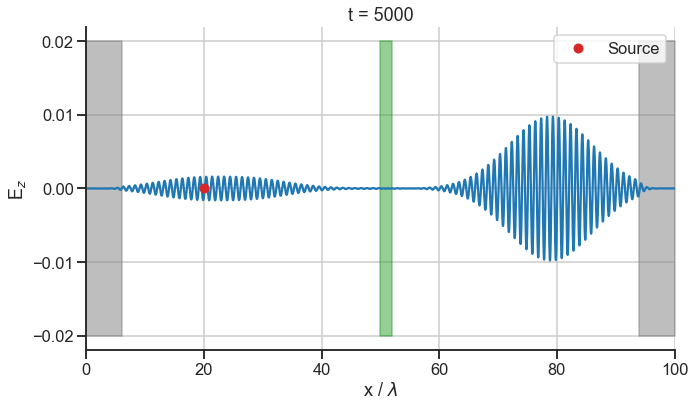

In [8]:
# Times to plot
t_list = [2500, 3000, 3500, 4000, 4500, 5000]

# Iterate over time steps
for i, t in enumerate(ts):

    # Yee algorithm to update fields
    E_z[1:-1] = D[1:-1] * (H_y[1:] - H_y[:-1]) / DELTA + C[1:-1] * E_z[1:-1]
    E_z[i_s] = E_z[i_s] - D[i_s] * j_s(t)

    H_y = B * (E_z[1:] - E_z[:-1]) / DELTA + A * H_y

    # Plot the electric field at the selected times
    if i in t_list:
        plot_E(x_E, E_z, title=f"t = {i}", show=False)
        plt.savefig(f"figures/CP_exercise_6_thin_{i}.pdf")

### Thick glass

In [9]:
# Grid point positions
x_E = np.arange(0, L+1) * DELTA
x_H = (np.arange(0, L) + 1 / 2) * DELTA

# Initialize fields
E_z = np.zeros_like(x_E)
H_y = np.zeros_like(x_H)

In [10]:
# Initialize auxiliary fields

C = (1 - (sigma(x_E) * TAU) / (2 * epsilon(x_E, mode="thick"))) / (1 + (sigma(x_E) * TAU) / (2 * epsilon(x_E, mode="thick")))
D = (TAU / epsilon(x_E, mode="thick")) / (1 + (sigma(x_E) * TAU) / (2 * epsilon(x_E, mode="thick")))

A = (1 - (sigma_star(x_H) * TAU) / (2 * mu(x_H))) / (1 + (sigma_star(x_H) * TAU) / (2 * mu(x_H)))
B = (TAU / mu(x_H)) / (1 + (sigma_star(x_H) * TAU) / (2 * mu(x_H)))

In [11]:
# Times to plot
t_list = [0, 2500, 5000]

# Indices for incident and reflected waves
I_INCIDENT = 2500
I_REFLECTION = 5000

# Iterate over all time steps
for i, t in enumerate(ts):
    
    # Yee algorithm to update fields
    E_z[1:-1] = D[1:-1] * (H_y[1:] - H_y[:-1]) / DELTA + C[1:-1] * E_z[1:-1]
    E_z[i_s] = E_z[i_s] - D[i_s] * j_s(t)

    H_y = B * (E_z[1:] - E_z[:-1]) / DELTA + A * H_y

    # Save the incident and reflected waves    
    if i == I_INCIDENT:
        E_z_incident = E_z.copy()

    if i == I_REFLECTION:
        E_z_reflection = E_z.copy()

Plot incident wave

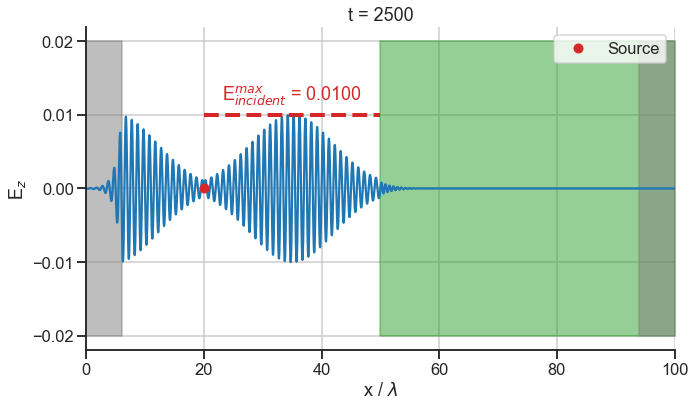

In [12]:
fig, ax = plot_E(x_E, E_z_incident, mode="thick", title=f"t = {I_INCIDENT}", show=False)

incidence_range = [20, 50]
mask_incidence = (x_E >= incidence_range[0]) & (x_E <= incidence_range[1])

max_incidence = np.max(np.abs(E_z_incident[mask_incidence]))
ax.plot(incidence_range, [max_incidence]*2, '--', color=colors[3], lw=4)

ax.text(
    np.mean(incidence_range), max_incidence+0.001, 
    r"E$_{incident}^{max}$ = "+ f"{max_incidence:.4f}",
    ha="center", va="bottom", color=colors[3]
)

plt.savefig(f"figures/CP_exercise_6_thick_{I_INCIDENT}.pdf")
plt.show()

Plot reflected wave

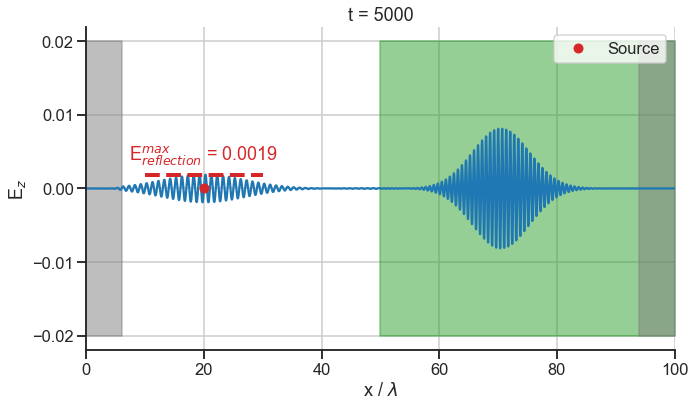

In [13]:
fig, ax = plot_E(x_E, E_z_reflection, mode="thick", title=f"t = {I_REFLECTION}", show=False)

reflection_range = [10, 30]
mask_reflection = (x_E >= reflection_range[0]) & (x_E <= reflection_range[1])

max_reflection = np.max(np.abs(E_z_reflection[mask_reflection]))
ax.plot(reflection_range, [max_reflection]*2, '--', color=colors[3], lw=4)

ax.text(
    np.mean(reflection_range), max_reflection+0.001, 
    r"E$_{reflection}^{max}$ = "+ f"{max_reflection:.4f}",
    ha="center", va="bottom", color=colors[3]
)

plt.savefig(f"figures/CP_exercise_6_thick_{I_REFLECTION}.pdf")
plt.show()

Estimation of reflection coefficient and deviation from theory

In [14]:
R = max_reflection**2 / max_incidence**2
R

0.0352886919686786

In [15]:
R_theo = (n-1)**2/(n+1)**2
R_theo

0.034965959415691715

In [16]:
(R - R_theo) / R_theo

0.00922990698324873